<a href="https://colab.research.google.com/github/gulmert89/dsBootcamp/blob/master/project5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graduation Project: Image Processing with Convolutional Neural Networks

Images of happy, shocked & sad faces.

---
# 1. Introduction

## 1.1 Importing Files & Modules

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")
%cd "/content/drive/My Drive/MertColab/project5/"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/MertColab/project5


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, os, io
import cv2
from zipfile import ZipFile
from PIL import Image

In [ ]:
shock_zip = ZipFile("shock.zip", "r")
happy_zip = ZipFile("happy.zip", "r")
sad_zip = ZipFile("sad.zip", "r")

In [ ]:
shock_img = []
happy_img = []
sad_img = []
for var_zip, var_img in zip((shock_zip, happy_zip, sad_zip),
                          (shock_img, happy_img, sad_img)):
    for img_name in var_zip.namelist():
        byte_data = var_zip.read(img_name)
        img = io.BytesIO(byte_data)
        img = np.array(Image.open(img))
        img = cv2.resize(img, (128, 128))
        var_img.append(img)
shock_img = np.array(shock_img)
happy_img = np.array(happy_img)
sad_img = np.array(sad_img)

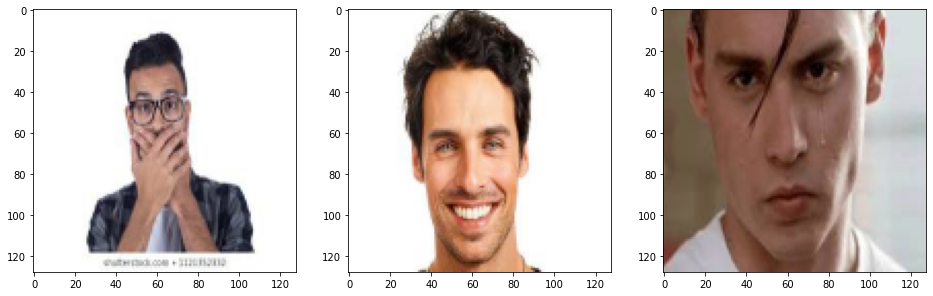

In [ ]:
plt.figure(figsize=(16,12))
plt.subplot(1,3,1)
plt.imshow(shock_img[np.random.randint(0,150)])
plt.subplot(1,3,2)
plt.imshow(happy_img[np.random.randint(0,150)])
plt.subplot(1,3,3)
plt.imshow(sad_img[np.random.randint(0,150)])
plt.show()

We are going to create an **X_train** which will contain arrays of the images & a **y_train** to hold the label numbers. There will be two points that need to be paid close attention.

1) Both **X_train** & **y_train** are sequential! First 150 images belong to *sad* class, the second 150 is for the *shock* class and the last sequence corresponds to the *happy* people. Thus, when training the model, one should remember to shuffle the batches to avoid any obstacle on the learning path.

2) **y_train** has only numbers, which are **0**, **1** and **2**. These are the *sad*, *shocked* & *happy* classes, respectively.

In [163]:
X_train = np.concatenate([sad_img, shock_img, happy_img], axis=0)
y_train = np.array([0]*150 + [1]*150 + [2]*150)

# We should choose 20 pictures from each classes for the test set
np.random.seed(42)
random_sad = np.random.choice(range(0, 150), 20, replace=False)
random_shock = np.random.choice(range(150, 300), 20, replace=False)
random_happy = np.random.choice(range(300, 450), 20, replace=False)
random_indices = np.concatenate([random_sad,
                                 random_shock,
                                 random_happy])

X_test = X_train[random_indices]
y_test = y_train[random_indices]
# let's remove the selected pictures from the train set
X_train = np.delete(X_train, random_indices, axis=0)
y_train = np.delete(y_train, random_indices, axis=0)

del random_sad, random_shock, random_happy, random_indices

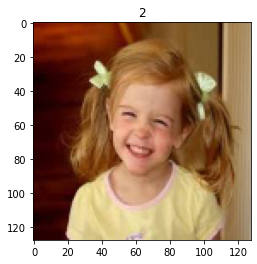

In [172]:
plt.imshow(X_test[55])
plt.title(y_test[55])
plt.show()

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array

In [ ]:
train_datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=45,
    width_shift_range=0.20,
    height_shift_range=0.20,
    brightness_range=None,
    shear_range=0.20,
    zoom_range=0.50,
    channel_shift_range=0.0,
    fill_mode="nearest",
    cval=0.0,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    dtype=None,
)

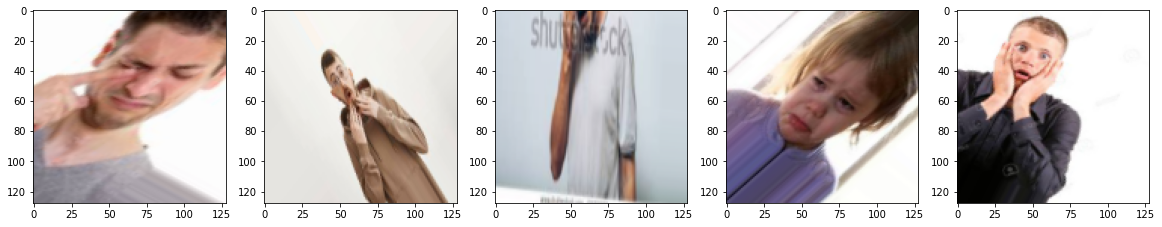

In [ ]:
plt.figure(figsize=(20,20))
for i, picture in enumerate(train_datagen.flow(X_train)):
    plt.subplot(1,5,i+1)
    plt.imshow(array_to_img(picture[0]))
    if i == 4 :  # 
        break
    
plt.show()